In [ ]:
### Dependencies instantiation ###

# Only run this cell once, if you haven't run it yet
# This ensures that you have all the necessary dependencies installed

using Pkg
Pkg.activate("../")
Pkg.instantiate()

In [1]:
### Imports ###

include("../src/QuantumPrimer.jl")
using .QuantumPrimer
using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers
using Pickle
using PyCall
using Distributions

#### Examples: run one cell

In [3]:
# Example of laminar vs turbulent flow

function basis_state(index, size)
    """ Create a basis state with a 1 at the index position. """
    state = zeros(size)
    state[index] = 1.0
    return state
end

function encode_state(psi)
    """ Encode a 2D array into a quantum state using two registers: |ψ> = sum_{i,j} ψ[i,j]*|i>⊗|j>. """
    n, m = size(psi)
    psi_state = zeros(Complex{Float64}, n*m)
    # The i register stores the row index and the j resgiter stores the column index
    for i in 1:n
        for j in 1:m
            # Create the basis states |i> and |j>
            basis_i = basis_state(i, n)
            basis_j = basis_state(j, m)
            # Compute the tensor product of basis states |i>⊗|j>
            tensor_product = kron(basis_i, basis_j)
            # Weight the basis state product by the contribution of ψ[i,j]
            psi_state += psi[i,j] * tensor_product
        end
    end
    return ArrayReg(psi_state)
end

function reduce_matrix(mat, factor)
    m, n = size(mat)
    reshape(sum(reshape(mat, factor, m÷factor, factor, n÷factor); dims=(1,3)), m÷factor, n÷factor) ./ factor^2
end

# Flow example of laminar vs turbulent
decision_boundary = 100
filename = "../data/dual/late_train_set.pkl"
cylinder_solutions = pyimport("pickle").load(open(filename, "r"))
# Encode states
inputs = [encode_state(solution) for solution in cylinder_solutions]
labels = vcat([-1 for i=1:decision_boundary], [1 for j=decision_boundary:length(inputs)-1]) #-1 = laminar ; 1 = turbulent
states = [encode_state(reduce_matrix(reshape(statevec(i), 64, 64)',16)) for i in inputs];

n = nqubits(states[1])
println("Total number of qubits: ", n)

# Cross-validation: 75% train & 25% test
Random.seed!(123)
cross_val_indices = sort(sample(collect(1:length(inputs)), Int64(round(0.25*length(inputs))), replace=false))
# Test set
te_states = [states[i] for i=cross_val_indices]
te_labels = [labels[i] for i=cross_val_indices]
# Train set
tr_states = [states[i] for i in 1:length(states) if !(i in cross_val_indices)]
tr_labels = [labels[i] for i in 1:length(labels) if !(i in cross_val_indices)]
# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

Total number of qubits: 4


#### Model parameters

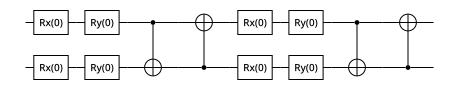

In [21]:
iters = 100 # number of iterations
lr = 0.02  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.

##### Cost #####
# obs_A = chain(n, put(1:n÷2 => circ_X(n÷2))) # QCNN
# obs_B = chain(n, put(n÷2+1:n => circ_Z(n÷2)))
obs_A = chain(n, put(1:n÷2 => circ_Xsum(n÷2))) # QNN
obs_B = chain(n, put(n÷2+1:n => circ_Zsum(n÷2)))
cost_fun = (output, state) -> covariance(output, state, obs_A, obs_B)
# activation = x -> sigmoid(10x)
activation = x -> hyperbolic_tangent(x, 30, 0.01) # 5000, 0.033
cost = GeneralCost(cost_fun, activation)
################

##### QCNN #####
# ansatz = circ_Ry_conv # circ_Ry_conv, circ_Ry_simple_conv, circ_SU4_conv
# circ1 = build_QCNN(n÷2, ansatz=ansatz)
# circ2 = build_QCNN(n÷2, ansatz=ansatz)
################

##### QNN #####
ansatz = circ_HEA
depth = 2 # ceil(Int, log2(n))
circ1 = build_QNN(n÷2, depth, ansatz=ansatz)
circ2 = build_QNN(n÷2, depth, ansatz=ansatz)
###############

##### Model #####
model1 = GeneralModel(n=n÷2, circ=circ1, ansatz=ansatz)
model2 = GeneralModel(n=n÷2, circ=circ2, ansatz=ansatz)
# # model1 = InvariantModel(n=n÷2, circ=circ1, ansatz=ansatz) # only valid for QCNN
# # model2 = InvariantModel(n=n÷2, circ=circ2, ansatz=ansatz)
#################

initialize_params(model1);
initialize_params(model2);

YaoPlots.plot(circ1)
# YaoPlots.plot(obs_A*obs_B)

#### Run

In [15]:
models = (model1, model2)
model_results = train_test_model(d1, d2, models, cost, iters, optim; regularization=:nothing, verbose=true);
# model_results = train_test_model(d1, d2, models, cost, iters, optim; lambda=1e-2, regularization=:l1, verbose=true);
# model_results = train_test_model(d1, d2, models, cost, iters, optim; lambda=1e-5, regularization=:l2, verbose=true);

model1_params, model2_params, loss_track, tr_track, te_track, tr_preds, te_preds = model_results;

Initial: loss = 0.9665236848879456, tr_acc = 0.5466666666666666, te_acc = 0.56
Iteration 20: loss = 0.6066728589421349, tr_acc = 0.8733333333333333, te_acc = 0.82
Iteration 40: loss = 0.46892973712821434, tr_acc = 0.9133333333333333, te_acc = 0.94
Iteration 60: loss = 0.43507897298332315, tr_acc = 0.96, te_acc = 0.94
Iteration 80: loss = 0.41926326758236926, tr_acc = 0.9533333333333334, te_acc = 0.94
Iteration 100: loss = 0.4147609917825057, tr_acc = 0.96, te_acc = 0.94
Final: loss = 0.4147609917825057, tr_acc = 0.96, te_acc = 0.94


#### Plot

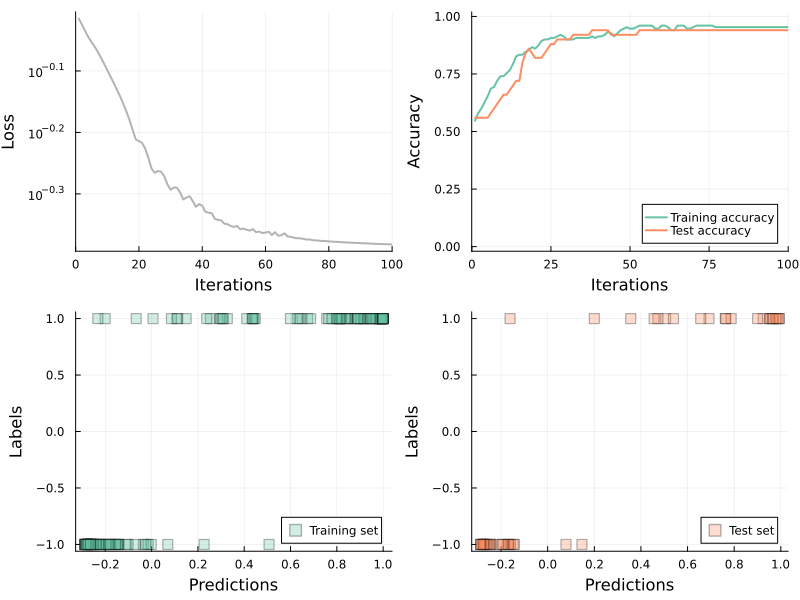

In [16]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
# Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [7]:
# savefig("double_qcnn_covariance.pdf")